# Install Transformers Library

In [2]:
!pip install transformers

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from huggingface_hub import PyTorchModelHubMixin

# specify GPU
device = torch.device("cuda")

In [12]:
device

device(type='cuda')

# Load train and test datasets

In [13]:
train_df = pd.read_csv("/content/drive/MyDrive/DL_train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/DL_test.csv")

In [14]:
train_df.head()

,text,humor
0,watch this swimmer disappear into winter storm...,False
1,"they laughed at reagan, too: trump's ideas wil...",False
2,"hey, are you cold? go over to the corner, it i...",True
3,cannot get a standing desk? these are almost a...,False
4,want to hear a joke about my penis? never mind...,True


In [ ]:
train_df['humor'] = train_df['humor'].apply(lambda x: 1 if x else 0)

In [ ]:
test_df.head()

,text,humor
0,thought up a reddit joke today. when is a tria...,True
1,how much do pirates pay for corn? a buck an ear!,True
2,hillary clinton sent her book to every gop can...,False
3,italian unions lambast new museum boss for wor...,False
4,life below the ocean’s surface wholly depends ...,False


In [ ]:
test_df['humor'] = test_df['humor'].apply(lambda x: 1 if x else 0)

In [ ]:
test_df.head()

,text,humor
0,thought up a reddit joke today. when is a tria...,1
1,how much do pirates pay for corn? a buck an ear!,1
2,hillary clinton sent her book to every gop can...,0
3,italian unions lambast new museum boss for wor...,0
4,life below the ocean’s surface wholly depends ...,0


In [ ]:
# check class distribution
train_df['humor'].value_counts(normalize = True)

humor
0    0.5
1    0.5
Name: proportion, dtype: float64

# Split train dataset into train, validation and test sets

In [15]:
X_train = train_df['text']
y_train = train_df['humor']

In [16]:
X_val, X_test, y_val, y_test = train_test_split(
    test_df['text'],
    test_df['humor'],
    test_size=0.3,
    random_state=42,
    stratify=test_df['humor']
)

# Import BERT Model and BERT Tokenizer

In [5]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

<Axes: >

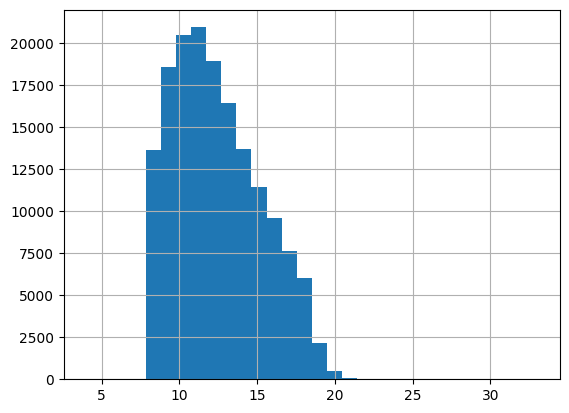

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in X_train]

pd.Series(seq_len).hist(bins = 30)

In [19]:
max_seq_len = 20

In [20]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length = max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    X_val.tolist(),
    max_length = max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    X_test.tolist(),
    max_length = max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

In [ ]:
type(tokens_train['input_ids'][0][0])

int

# Convert Integer Sequences to Tensors

In [21]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.tolist())

# Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 512

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [7]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture on top of BERT

In [6]:
class BERT_Arch(nn.Module, PyTorchModelHubMixin):

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.1)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from pytorch

# define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)

# Find Class Weights

In [ ]:
# from sklearn.utils.class_weight import compute_class_weight

# #compute the class weights
# class_wts = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

# print(class_wts)

# # convert class weights to tensor
# weights= torch.tensor(class_wts, dtype=torch.float)
# weights = weights.to(device)

In [ ]:
# loss function
cross_entropy  = nn.NLLLoss()

# number of training epochs
epochs = 10

# Fine-Tune BERT

In [ ]:
# function to train the model
def train():

  # set model to train mode
  model.train()

  total_loss, num_correct, num_samples = 0, 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step, batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # calculate accuracy for this batch
    num_correct_batch = np.sum(np.argmax(preds, axis=1) == labels.detach().cpu().numpy())
    num_correct += num_correct_batch
    num_samples += len(labels)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # compute the average accuracy of the epoch
  avg_accuracy = num_correct / num_samples

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, avg_accuracy, total_preds

In [ ]:
# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, num_correct, num_samples = 0, 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

      # calculate accuracy for this batch
      num_correct_batch = np.sum(np.argmax(preds, axis=1) == labels.detach().cpu().numpy())
      num_correct += num_correct_batch
      num_samples += len(labels)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # compute the average accuracy of the epoch
  avg_accuracy = num_correct / num_samples

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, avg_accuracy, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:}  / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, train_accuracy, _ = train()

    #evaluate model
    valid_loss, valid_accuracy, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print(f'Training Accuracy: {train_accuracy:.3f}')
    print(f'Validation Accuracy: {valid_accuracy:.3f}')


 Epoch 1  / 10
  Batch    50  of    313.
  Batch   100  of    313.
  Batch   150  of    313.
  Batch   200  of    313.
  Batch   250  of    313.
  Batch   300  of    313.

Evaluating...
  Batch    50  of     55.

Training Loss: 0.373
Validation Loss: 0.252
Training Accuracy: 0.851
Validation Accuracy: 0.902

 Epoch 2  / 10
  Batch    50  of    313.
  Batch   100  of    313.
  Batch   150  of    313.
  Batch   200  of    313.
  Batch   250  of    313.
  Batch   300  of    313.

Evaluating...
  Batch    50  of     55.

Training Loss: 0.246
Validation Loss: 0.211
Training Accuracy: 0.905
Validation Accuracy: 0.918

 Epoch 3  / 10
  Batch    50  of    313.
  Batch   100  of    313.
  Batch   150  of    313.
  Batch   200  of    313.
  Batch   250  of    313.
  Batch   300  of    313.

Evaluating...
  Batch    50  of     55.

Training Loss: 0.223
Validation Loss: 0.194
Training Accuracy: 0.914
Validation Accuracy: 0.925

 Epoch 4  / 10
  Batch    50  of    313.
  Batch   100  of    313.
  

# Load Saved Model

In [24]:
# load weights of best model
path = 'saved_weights.pt'
model = BERT_Arch(bert).to(device)
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [25]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [26]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

       False       0.95      0.93      0.94      6000
        True       0.93      0.96      0.94      6000

    accuracy                           0.94     12000
   macro avg       0.94      0.94      0.94     12000
weighted avg       0.94      0.94      0.94     12000



In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,5552,448
1,270,5730


## Save weights to huggingface

In [27]:
from huggingface_hub import notebook_login
from huggingface_hub import Repository

In [28]:
notebook_login()

In [ ]:
config = model.bert.config

In [ ]:
config.save_pretrained("finetuned-bert")

In [ ]:
model.save_pretrained("finetuned-bert")

In [ ]:
tokenizer.save_pretrained("finetuned-bert")

('finetuned-bert/tokenizer_config.json',
 'finetuned-bert/special_tokens_map.json',
 'finetuned-bert/vocab.txt',
 'finetuned-bert/added_tokens.json',
 'finetuned-bert/tokenizer.json')

In [ ]:
model.push_to_hub("Jiahao123/finetuned-bert")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Jiahao123/finetuned-bert/commit/06a4a48f8d02d3d564550fa114b9b11de9d41def', commit_message='Push model using huggingface_hub.', commit_description='', oid='06a4a48f8d02d3d564550fa114b9b11de9d41def', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
tokenizer.push_to_hub("Jiahao123/finetuned-bert")

CommitInfo(commit_url='https://huggingface.co/Jiahao123/finetuned-bert/commit/a7ac790b749c11a8e809bd0552dcf56761075dcb', commit_message='Upload tokenizer', commit_description='', oid='a7ac790b749c11a8e809bd0552dcf56761075dcb', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
config.push_to_hub("Jiahao123/finetuned-bert")

CommitInfo(commit_url='https://huggingface.co/Jiahao123/finetuned-bert/commit/94cab362733e4362269e48953b09a7151f8206f9', commit_message='Upload config', commit_description='', oid='94cab362733e4362269e48953b09a7151f8206f9', pr_url=None, pr_revision=None, pr_num=None)

## Test loading model from hugging face

In [29]:
# test loading the model from huggingface
bert = AutoModel.from_pretrained('bert-base-uncased')
model = BERT_Arch.from_pretrained("Jiahao123/finetuned-bert", bert=bert).to(device)

In [30]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [31]:
# model's performance
preds = np.argmax(preds, axis = 1)
preds

array([1, 0, 0, ..., 0, 0, 1])

In [32]:
test_y.detach().cpu().numpy()

array([ True,  True, False, ..., False, False,  True])

In [33]:
print(classification_report(test_y.detach().cpu().numpy(), preds))

              precision    recall  f1-score   support

       False       0.95      0.93      0.94      6000
        True       0.93      0.95      0.94      6000

    accuracy                           0.94     12000
   macro avg       0.94      0.94      0.94     12000
weighted avg       0.94      0.94      0.94     12000



Weights are saved to my huggingface, at repo ```Jiahao123/finetuned-bert```